In [1]:
import sys
import os
import numpy as np
import scipy
import matplotlib
from scipy.special import lambertw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter
from lmfit import Model
from lmfit.parameter import Parameters
from importlib.metadata import version
%matplotlib inline

def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
pkgs = ['numpy', 'scipy', 'matplotlib', 'lmfit']
print(f'python: {sys.version}')
for p in pkgs:
    print(p+': '+sys.modules[p].__version__)

python: 3.10.9 (main, Mar  1 2023, 18:23:06) [GCC 11.2.0]
numpy: 1.23.5
scipy: 1.10.0
matplotlib: 3.7.0
lmfit: 1.1.0


In [2]:
# measurement times and repetitions

T_SPAD = 20. # measurement time
reps_SPAD = 30 # number of repeated measurements

syml_th = -4 # symlog threshold
plt.rcParams['hatch.linewidth'] = 2

In [3]:
def symlog_ytick(x, pos):
    if x == 0:
        return f'$\pm 10^{{{syml_th}}}$'
    lx = int(np.log10(abs(x)))
    if x < 0:
        pre = '-'
    else:
        pre = ''
    if lx > syml_th:
        return f'${pre}10^{{{lx}}}$'
    else:
        return None

# Models

In [4]:
def RateNP(mu,dt):
    return 1./(1/mu + dt)
def RateP(mu,dt):
    return mu*np.exp(-mu*dt)

# Inverse formulas

In [5]:
def InvRateNP(r,dt):
    return 1./(1/r-dt)
def InvRateP(r,dt):
    return -lambertw(-r*dt).real/dt

# Fitting functions

In [6]:
def NonlinearityModel(f,mu,dc,*pars):
    ra  = f(mu/2+dc,*pars)
    rab = f(mu+dc,*pars)
    return (rab,(2*ra/rab)-1.)
def FitFuncNP(r,dc,dt):
    mu = InvRateNP(r,dt)
    return NonlinearityModel(RateNP,mu-dc,dc,dt)[1]
def FitFuncP(r,dc,dt):
    mu = InvRateP(r,dt)
    return NonlinearityModel(RateP,mu-dc,dc,dt)[1]

# SPAD data

In [7]:
files = \
['AQRH.txt',
 'AQ4C.txt',
 'COUNT.txt',
 'ID120.txt']
names = list(map(os.path.basename,files))

In [8]:
dat = [np.genfromtxt(f, encoding='utf-8-sig') for f in files]
for i,d in enumerate(dat):
    dat[i] = np.array(np.split(d, len(d)/reps_SPAD))

In [9]:
delta_raw = [(d[:,:,0]+d[:,:,1])/d[:,:,2]-1. for d in dat]

rate_means = [np.mean(d[:,:,2]/T_SPAD, axis=1)*1e-6 for d in dat]
delta_means = [np.mean(delta, axis=1) for delta in delta_raw]
delta_errs = [np.std(delta, axis=1, ddof=1)/np.sqrt(reps_SPAD) for delta in delta_raw] # standard error of the mean

In [10]:
modelNP = Model(FitFuncNP)
modelP = Model(FitFuncP)

paramsNP = [Parameters() for i in range(len(rate_means))]
paramsP = [Parameters() for i in range(len(rate_means))]

for pNP, rat in zip(paramsNP, rate_means):
    pNP.add('dc', value=1e-4, min=0., max=np.inf)
    pNP.add('dt', value=0.02, min=0., max=1./np.max(rat))
for pP, rat in zip(paramsP, rate_means):
    pP.add('dc', value=1e-4, min=0., max=np.inf)
    pP.add('dt', value=0.02, min=0., max=1./(np.e*np.max(rat)))


resultsNP = [modelNP.fit(d, r=r, params=p, weights=1./ye) \
             for d,r,ye,p in zip(delta_means,rate_means,delta_errs,paramsNP)]
resultsP = [modelP.fit(d, r=r, params=p, weights=1./ye) \
            for d,r,ye,p in zip(delta_means,rate_means,delta_errs,paramsP)]

In [11]:
dc_fit = [r.best_values['dc'] for r in resultsNP]
dt_fit = [r.best_values['dt'] for r in resultsNP]

# Main SPAD figure

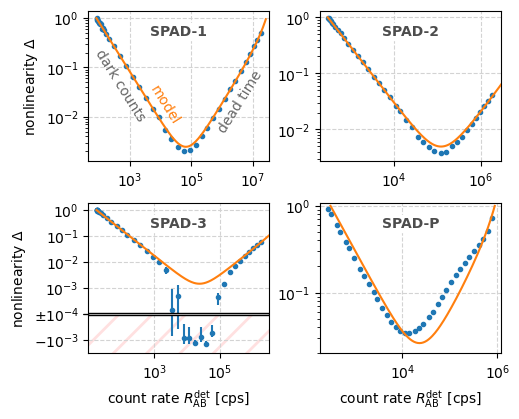

In [12]:
def PlotSPAD():
    bigfontsize = 10
    pcolor = 'tab:blue'   # plot points
    mcolor = 'tab:orange' # model curve

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5,4))
    titles = ['SPAD-'+str(n) for n in range(1,4)]+['SPAD-P']

    ax_syml = axes[1,0] 

    for ax, rate, delta, derr, rNP, tit in \
        zip(axes.reshape(-1), rate_means, delta_means, delta_errs, resultsNP, titles):
        
        # axes and grids

        ax.set_xscale('log')

        if ax == ax_syml:
            ax.set_yscale('symlog', linthresh=10**syml_th, linscale=0.001)
            ax.yaxis.set_major_formatter(FuncFormatter(symlog_ytick))
        else:
            ax.set_yscale('log')


        ax.grid(visible=True, which='major', color='lightgray', linestyle='--', zorder=0)
        ax.set_axisbelow(True)
        
        # error-bar data plot

        ax.errorbar(rate*1e6, delta, yerr=derr, fmt='o', markersize=3., zorder=1, color=pcolor)

        ax.set_xlim(ax.get_xlim())
        ax.set_ylim(top=ax.get_ylim()[1])
        
        # fits plot

        mu = np.logspace(-7, 3, 500)
        nlp = NonlinearityModel(RateNP,mu,rNP.params['dc'].value,rNP.params['dt'].value)
        nlp = np.array(nlp)
        nlp[0] = nlp[0]*1e6
        ax.plot(*nlp, color=mcolor, zorder=3)
        
        # labels and annotations

        if ax in axes[-1,:]:
            ax.set_xlabel(r'count rate $R^{\mathrm{det}}_{\mathrm{AB}}$ [cps]')
        if ax in axes[:,0]:
            ax.set_ylabel(r'nonlinearity $\Delta$')

        ax.annotate(tit, xy=(0.5, 0.91), xycoords='axes fraction', ha='center', va='top',
                    fontsize=bigfontsize, weight='bold', c='0.3',
                    bbox=dict(color='w', boxstyle=('square, pad=0.1')))


    axes[1,1].set_ylim(bottom=0.02)

    fig.tight_layout(pad=0, h_pad=0.6, w_pad=0.6)
    
    axes[0,0].annotate('dark counts', xy=(0.02, 0.76), rotation=-58, xycoords='axes fraction',
                       ha='left', va='top', fontsize=bigfontsize, c='0.4')
    axes[0,0].annotate('dead time', xy=(0.98, 0.62), rotation=58, xycoords='axes fraction',
                       ha='right', va='top', fontsize=bigfontsize, c='0.4')
    axes[0,0].annotate('model', xy=(0.52, 0.23), rotation=-58, xycoords='axes fraction',
                       ha='right', va='bottom', fontsize=bigfontsize, c=mcolor)

    # visual patches

    xb = ax_syml.get_xlim()
    yb = ax_syml.get_ylim()

    axes_break = patches.Rectangle((xb[0], -1.08e-4), xb[1]-xb[0],
                           2.16e-4, fc='w', ec='k', zorder = 3)
    ax_syml.add_patch(axes_break)
    neg_hatches = patches.Rectangle((xb[0], yb[0]), xb[1]-xb[0],
                           0-yb[0], fc='w', ec='#ffe0e0', lw=0, hatch='/', zorder = 0)
    ax_syml.add_patch(neg_hatches)

    plt.show()
    
    return fig

fig_SPAD = PlotSPAD()

# P-NP models

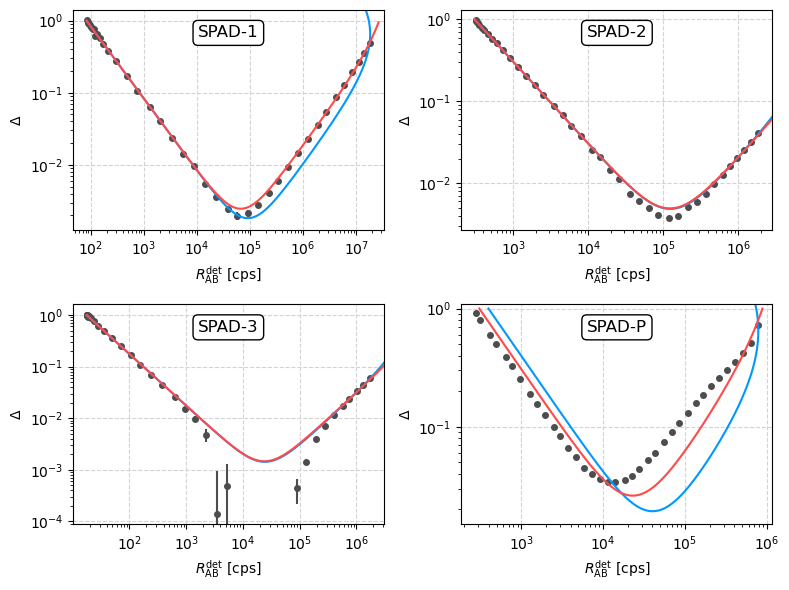

In [19]:
def Plot_P_NP():
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
    titles = ['SPAD-'+str(n) for n in range(1,4)]+['SPAD-P']

    for ax, rate, delta, derr, rNP, rP, tit in \
        zip(axes.reshape(-1), rate_means, delta_means, delta_errs, resultsNP, resultsP, titles):

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.grid(visible=True, which='major', color='lightgray', linestyle='--', zorder=0)
        ax.set_axisbelow(True)

        ax.errorbar(rate[delta > 0]*1e6, delta[delta > 0], yerr=derr[delta > 0],
                   fmt='o', markersize=4., zorder=1, color='0.3')

        ax.set_xlim(ax.get_xlim())
        ax.set_ylim(top=ax.get_ylim()[1])

        mu = np.logspace(-7, 3, 500)
        nlp = [ NonlinearityModel(RateNP,mu,rNP.params['dc'].value,rNP.params['dt'].value),
               NonlinearityModel(RateP,mu,rP.params['dc'].value,rP.params['dt'].value) ]
        nlp = np.array(nlp)
        nlp[:,0] = nlp[:,0]*1e6
        ax.plot(*nlp[1], color='#0098ff', zorder=2)
        ax.plot(*nlp[0], color='#ff4a4a', zorder=3)

        ax.set_xlabel(r'$R^{\mathrm{det}}_{\mathrm{AB}}$ [cps]')
        ax.set_ylabel(r'$\Delta$')

        ax.annotate(tit, xy=(0.5, 0.93), xycoords='axes fraction', ha='center', va='top',
                    fontsize=12, bbox=dict(boxstyle='round', color='w', ec='k'))


    axes[1,1].set_ylim(bottom=0.015)

    fig.tight_layout()

    plt.show()
    
    return fig
    
fig_PNP = Plot_P_NP()

In [20]:
fig_PNP.savefig('fig_S8.pdf')